In [ ]:
%tensorflow_version 1.x
import tensorflow as tf

In [ ]:
print('Tensorflow version: {}'.format(tf.__version__) )

Tensorflow version: 1.15.2


In [ ]:
!git clone https://github.com/NVlabs/stylegan2.git

Cloning into 'stylegan2'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 138 (delta 4), reused 10 (delta 4), pack-reused 127
Receiving objects: 100% (138/138), 599.47 KiB | 1.05 MiB/s, done.
Resolving deltas: 100% (62/62), done.


In [ ]:
%cd /content/stylegan2

/content/stylegan2


In [ ]:
!pip install googledrivedownloader

In [ ]:
import pretrained_networks
from google_drive_downloader import GoogleDriveDownloader as gdd

url = 'https://drive.google.com/open?id=1WNQELgHnaqMTq3TlrnDaVkyrAH8Zrjez'
#'https://drive.google.com/open?id=1BHeqOZ58WZ-vACR2MJkh1ZVbJK2B-Kle'
model_id = url.replace('https://drive.google.com/open?id=', '')

network_pkl = '/content/models/model_%s.pkl' % model_id#(hashlib.md5(model_id.encode()).hexdigest())
gdd.download_file_from_google_drive(file_id=model_id,
                                    dest_path=network_pkl)

_G, _D, Gs = pretrained_networks.load_networks(network_pkl)

In [ ]:
Gs.vars["dlatent_avg"].value().eval()

array([ 4.69399601e-01,  5.19922614e-01,  7.61840940e-01, -4.57984209e-02,
        1.06809235e+00,  1.39685225e+00,  1.52100205e-01,  6.83534145e-02,
        1.80047542e-01,  9.98223424e-02,  1.26816773e+00,  1.71921492e-01,
        2.20608759e+00,  1.22328341e+00,  1.08799422e+00,  1.80976018e-02,
       -3.34363043e-01, -5.40801063e-02,  8.36406529e-01,  1.22908545e+00,
       -4.34626937e-02,  1.14429832e-01, -1.59501582e-01,  9.67764378e-01,
        4.06472445e-01, -6.25084192e-02, -2.49396086e-01,  3.99684794e-02,
       -2.61142880e-01,  7.24299788e-01, -8.80684704e-02, -2.28114389e-02,
        3.49023879e-01,  2.19486535e-01, -1.87090114e-01, -9.51050520e-02,
       -1.00772254e-01,  1.19091058e+00, -7.59095922e-02,  3.96770507e-01,
       -1.68704450e-01,  3.90192002e-01, -4.01386619e-01, -5.28093427e-02,
       -1.11889228e-01,  4.28982079e-01,  8.78612757e-01,  3.99716914e-01,
        6.64873898e-01,  3.26022178e-01,  6.81805730e-01,  1.31156373e+00,
        1.02016938e+00,  

In [ ]:
import numpy as np

def generate_zs_from_seeds(seeds):
    zs = []
    for seed_idx, seed in enumerate(seeds):
        rnd = np.random.RandomState(seed)
        z = rnd.randn(1, *Gs.input_shape[1:]) # [minibatch, component]
        zs.append(z)
    return zs

In [ ]:
!pip install tqdm

In [ ]:
import dnnlib
import dnnlib.tflib as tflib
import PIL.Image
from tqdm import tqdm

noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]

def generate_images(zs, truncation_psi):
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    if not isinstance(truncation_psi, list):
        truncation_psi = [truncation_psi] * len(zs)
        
    imgs = []
    for z_idx, z in tqdm(enumerate(zs)):
        Gs_kwargs.truncation_psi = truncation_psi[z_idx]
        noise_rnd = np.random.RandomState(1) # fix noise
        tflib.set_vars({var: noise_rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
        images = Gs.run(z, None, **Gs_kwargs) # [minibatch, height, width, channel]
        imgs.append(PIL.Image.fromarray(images[0], 'RGB'))
    return imgs

def generate_images_from_seeds(seeds, truncation_psi):
    return generate_images(generate_zs_from_seeds(seeds), truncation_psi)

In [ ]:
# generate some random seeds
seeds = np.random.randint(10000000, size=9)
print(seeds)

zs = generate_zs_from_seeds(seeds)
imgs = generate_images(zs, .7)

[3865000 3666545  495471 5616913 9360151 6996229 5748366 5620480 4487395]


9it [00:01,  6.90it/s]


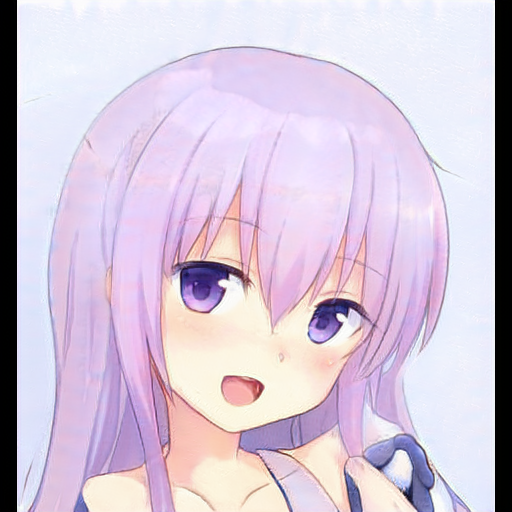

In [ ]:
imgs[0]

In [ ]:
from math import ceil

def createImageGrid(images, scale=0.25, rows=1):
   w,h = images[0].size
   w = int(w*scale)
   h = int(h*scale)
   height = rows*h
   cols = ceil(len(images) / rows)
   width = cols*w
   canvas = PIL.Image.new('RGBA', (width,height), 'white')
   for i,img in enumerate(images):
     img = img.resize((w,h), PIL.Image.ANTIALIAS)
     canvas.paste(img, (w*(i % cols), h*(i // cols))) 
   return canvas

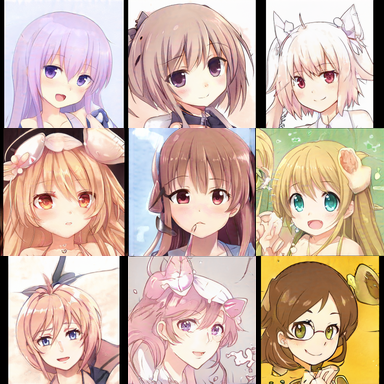

In [ ]:
createImageGrid(imgs, rows=3)

In [ ]:
def interpolate(zs, steps):
   out = []
   for i in range(len(zs)-1):
    for index in range(steps):
     fraction = index/float(steps) 
     out.append(zs[i+1]*fraction + zs[i]*(1-fraction))
   return out

In [ ]:
seeds = np.random.randint(10000000, size=2)
zs = generate_zs_from_seeds(seeds)
imgs = generate_images(interpolate(zs, 7), 0.5)

7it [00:00,  7.28it/s]


7it [00:00,  7.57it/s]


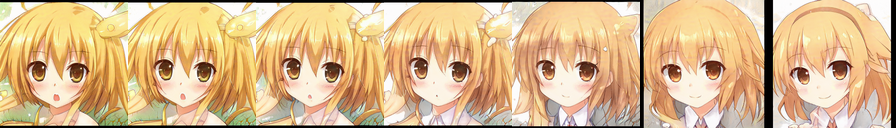

In [ ]:
seeds = np.random.randint(10000000, size=2)
zs = generate_zs_from_seeds(seeds)
imgs = generate_images(interpolate(zs, 7), 0.5)
createImageGrid(imgs, rows=1)

In [ ]:
import scipy

grid_size = [3, 3]
image_shrink = 1
image_zoom = 1
duration_sec = 5
smoothing_sec = 1.0
fps = 15
codec = 'libx264'
bitrate = '2M'#4M
random_seed = np.random.randint(0, 999)#405
filename = 'random_grid_%s.gif' % random_seed
truncation_psi= 0.7

num_frames = int(np.rint(duration_sec * fps))
random_state = np.random.RandomState(random_seed)

# Generate latent vectors
shape = [num_frames, np.prod(grid_size)] + Gs.input_shape[1:] # [frame, image, channel, component]
all_latents = random_state.randn(*shape).astype(np.float32)
all_latents = scipy.ndimage.gaussian_filter(all_latents, [smoothing_sec * fps] + [0] * len(Gs.input_shape), mode='wrap')
all_latents /= np.sqrt(np.mean(np.square(all_latents)))


def create_image_grid(images, grid_size=None):
    assert images.ndim == 3 or images.ndim == 4
    num, img_h, img_w, channels = images.shape

    if grid_size is not None:
        grid_w, grid_h = tuple(grid_size)
    else:
        grid_w = max(int(np.ceil(np.sqrt(num))), 1)
        grid_h = max((num - 1) // grid_w + 1, 1)

    grid = np.zeros([grid_h * img_h, grid_w * img_w, channels], dtype=images.dtype)
    for idx in range(num):
        x = (idx % grid_w) * img_w
        y = (idx // grid_w) * img_h
        grid[y : y + img_h, x : x + img_w] = images[idx]
    return grid

# Frame generation func for moviepy.
def make_frame(t):
    frame_idx = int(np.clip(np.round(t * fps), 0, num_frames - 1))
    latents = all_latents[frame_idx]
    fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    images = Gs.run(latents, None, truncation_psi=truncation_psi,
                          randomize_noise=False, output_transform=fmt, 
                          minibatch_size=16)

    grid = create_image_grid(images, grid_size)
    if image_zoom > 1:
        grid = scipy.ndimage.zoom(grid, [image_zoom, image_zoom, 1], order=0)
    if grid.shape[2] == 1:
        grid = grid.repeat(3, 2) # grayscale => RGB
    return grid

# Generate video.
import moviepy.editor
video_clip = moviepy.editor.VideoClip(make_frame, duration=duration_sec)

# Use this if you want to generate .mp4 video instead
# video_clip.write_videofile("interpolate3x2-2m.mp4", fps=fps, codec=codec, bitrate=bitrate)

video_clip.write_gif(filename,fps=15)


[MoviePy] Building file random_grid_261.gif with imageio


 99%|█████████▊| 75/76 [02:18<00:01,  1.84s/it]


In [ ]:
#video_clip.write_videofile("interpolate.mp4", fps=15, codec='libx264', bitrate='2M')
video_clip.write_gif(filename,fps=15)


[MoviePy] Building file random_grid_261.gif with imageio


 99%|█████████▊| 75/76 [02:18<00:01,  1.85s/it]


In [ ]:
from IPython import display as ipythondisplay
import io
import os
import base64
from IPython.display import HTML

def show_video(vid):
  #mp4list = [video
  #if len(mp4list) > 0:
  ext = os.path.splitext(vid)[-1][1:]
  video = io.open(vid, 'r+b').read()
  #encoded = base64.b64encode(video)
  ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
              loop controls style="height: 400px;">
              <source src="data:video/{1}';base64,{0}" type="video/{1}" />
              </video>'''.format(base64.b64encode(video).decode('ascii'), ext)))
  
show_video(filename)